In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import category_encoders
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [3]:
def bal_acc(y_true,y_pred,weights=None):
    #weights should be provided as list of weights for each class to sum up to 1
    temp1=np.unique(y_true,return_counts=True)[1]
    temp2=confusion_matrix(y_true,y_pred)
    acc_bal=np.sum(np.diag(temp2)*(temp1/np.sum(temp1))/temp1)
    if len(weights)==0:
        acc_weig=acc_bal
    elif len(weights)!=len(temp1):
        print('provide weight for each class')
    else:
        acc_weig=np.sum(np.diag(temp2)*weights/temp1)
    return (acc_weig,acc_bal)

In [4]:
train=pd.read_csv(os.path.join(os.getcwd(),'train.csv.zip'))

In [5]:
#class_weights={1: 0.37062, 2: 0.49657,3:0.05947,4:0.018,5:0.018,6:0.018,7:0.018}
class_weights={1: 0.37053, 2: 0.49657,3:0.05947,4:0.00106,5:0.01287,6:0.02698,7:0.03238}
list_weight=compute_class_weight(class_weights,np.unique(train['Cover_Type']),train['Cover_Type'])

In [6]:
def bal_acc2(y_true,y_pred):
    #weights should be provided as list of weights for each class to sum up to 1
    temp1=np.unique(y_true,return_counts=True)[1]
    temp2=confusion_matrix(y_true,y_pred)
    acc_bal=np.sum(np.diag(temp2)*(temp1/np.sum(temp1))/temp1)
    weights=[0.37053, 0.49657, 0.05947, 0.00106, 0.01287, 0.02698, 0.03238]
    acc_weig=np.sum(np.diag(temp2)*weights/temp1)
    return (acc_weig)
from sklearn.metrics import make_scorer
my_score = make_scorer(bal_acc2)

In [7]:
#columns
target_col='Cover_Type'
soil_type=[x for x in train.columns if 'Soil' in x]
wild_type=[x for x in train.columns if 'Wilderness' in x]
vert_dist=['Vertical_Distance_To_Hydrology']
hor_dist=['Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',  'Horizontal_Distance_To_Fire_Points']
hill_feat=['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']
other_feat=['Elevation', 'Aspect', 'Slope']

In [8]:
soil_names = {
0: 'Cathedral family - Rock outcrop complex, extremely stony.',
1: 'Vanet - Ratake families complex, very stony.',
2: 'Haploborolis - Rock outcrop complex, rubbly.',
3: 'Ratake family - Rock outcrop complex, rubbly.',
4: 'Vanet family - Rock outcrop complex complex, rubbly.',
5: 'Vanet - Wetmore families - Rock outcrop complex, stony.',
6: 'Gothic family.',
7: 'Supervisor - Limber families complex.',
8: 'Troutville family, very stony.',
9: 'Bullwark - Catamount families - Rock outcrop complex, rubbly.',
10: 'Bullwark - Catamount families - Rock land complex, rubbly.',
11: 'Legault family - Rock land complex, stony.',
12: 'Catamount family - Rock land - Bullwark family complex, rubbly.',
13: 'Pachic Argiborolis - Aquolis complex.',
14: 'unspecified in the USFS Soil and ELU Survey.',
15: 'Cryaquolis - Cryoborolis complex.',
16: 'Gateview family - Cryaquolis complex.',
17: 'Rogert family, very stony.',
18: 'Typic Cryaquolis - Borohemists complex.',
19: 'Typic Cryaquepts - Typic Cryaquolls complex.',
20: 'Typic Cryaquolls - Leighcan family, till substratum complex.',
21: 'Leighcan family, tibbll substratum, extremely bouldery.',
22: 'Leighcan family, till substratum - Typic Cryaquolls complex.',
23: 'Leighcan family, extremely stony.',
24: 'Leighcan family, warm, extremely stony.',
25: 'Granile - Catamount families complex, very stony.',
26: 'Leighcan family, warm - Rock outcrop complex, extremely stony.',
27: 'Leighcan family - Rock outcrop complex, extremely stony.',
28: 'Como - Legault families complex, extremely stony.',
29: 'Como family - Rock land - Legault family complex, extremely stony.',
30: 'Leighcan - Catamount families complex, extremely stony.',
31: 'Catamount family - Rock outcrop - Leighcan family complex, extremely stony.',
32: 'Leighcan - Catamount families - Rock outcrop complex, extremely stony.',
33: 'Cryorthents - Rock land complex, extremely stony.',
34: 'Cryumbrepts - Rock outcrop - Cryaquepts complex.',
35: 'Bross family - Rock land - Cryumbrepts complex, extremely stony.',
36: 'Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.',
37: 'Leighcan - Moran families - Cryaquolls complex, extremely stony.',
38: 'Moran family - Cryorthents - Leighcan family complex, extremely stony.',
39: 'Moran family - Cryorthents - Rock land complex, extremely stony.',}

In [9]:
def add_cat(df,soil_type,wild_type,soil_names,hill_feat):
    #first add categories
    df['soil_cat']=np.dot(df[soil_type],np.arange(len(soil_type)).reshape((len(soil_type),1)))
    df['wild_cat']=np.dot(df[wild_type],np.arange(len(wild_type)).reshape((len(wild_type),1)))
    df['soil_wild_cat']=df['soil_cat']*10+df['wild_cat']
    #next add names
    df["soil_name"]=df['soil_cat'].map(soil_names)
    #add some text features
    #check how stony is the soil
    df['stone_cat']=0
    df['stone_cat']+=df["soil_name"].str.contains(', rubbly')*1
    df['stone_cat']+=df["soil_name"].str.contains(', stony')*2
    df['stone_cat']+=df["soil_name"].str.contains('very stony')*3
    df['stone_cat']+=df["soil_name"].str.contains('extremely stony')*4
    df['wild_stone']=df['stone_cat']*10+df['wild_cat']    
    #check if Rock is in name
    df['Rock_cat']=df["soil_name"].str.contains('Rock outcrop')*1+df["soil_name"].str.contains('Rock land')*2
    df['if_Leighcan']=df["soil_name"].str.contains('Leighcan')*1
    df['if_Cryaquolls']=df["soil_name"].str.contains('Cryaquolls')*1
    df['if_Catamount']=df["soil_name"].str.contains('Catamount')*1
    df['if_Cryorthents']=df["soil_name"].str.contains('Cryorthents')*1    
    #relative distances
    df['Hyd_2_Road']=df['Horizontal_Distance_To_Hydrology']/(df['Horizontal_Distance_To_Roadways']+df['Horizontal_Distance_To_Hydrology']+0.0001)
    df['Hyd_2_Fire']=df['Horizontal_Distance_To_Hydrology']/(df['Horizontal_Distance_To_Fire_Points']+df['Horizontal_Distance_To_Hydrology']+0.0001)
    df['Fire_2_Road']=df['Horizontal_Distance_To_Fire_Points']/(df['Horizontal_Distance_To_Roadways']+df['Horizontal_Distance_To_Fire_Points']+0.0001)
    #add average shade
    df['av_shade']=(df[hill_feat[0]]+df[hill_feat[1]]+df[hill_feat[2]])/3
    df['dif_shade']=(df[hill_feat[0]]-df[hill_feat[2]])
    #add sin of Aspect and slope
    df['Sin_Aspect'] = np.sin(np.radians(df['Aspect']))
    df['Sin_Slope'] = np.sin(np.radians(df['Slope']))
    df["world_side"]=np.logical_and(df['Aspect']>90,df['Aspect']<=180)*1+np.logical_and(df['Aspect']>180,df['Aspect']<=270)*2+np.logical_and(df['Aspect']>270,df['Aspect']<=360)*3
    #below water
    df['if_below']=(df['Vertical_Distance_To_Hydrology']<0)*1
    df['Vertical_Distance_To_Hydrology']=np.abs(df['Vertical_Distance_To_Hydrology'])
    #convert to sqrt
    
    return df

In [10]:
train_new=add_cat(train,soil_type,wild_type,soil_names,hill_feat)

In [11]:
#below are features to use for traning
learn_cols=['Elevation',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'soil_cat', 'wild_cat', 'stone_cat', 'Hyd_2_Road', 'Hyd_2_Fire', 'Fire_2_Road', 'av_shade',
       'Sin_Aspect', 'Sin_Slope','dif_shade',"world_side",'wild_stone','soil_wild_cat','if_below', 'Rock_cat', 'if_Leighcan',
       'if_Cryaquolls', 'if_Catamount', 'if_Cryorthents']

### Encoding

may work better here as now I need to encode only 2 categories;

In [12]:
def full_enc_6(df,features,target_col,alpha,n_splits,encode_targets,df_test=None):
    #have some troubles with index so reset and save
    temp_index=df.index
    df=df.reset_index(drop=True)
    #find unique values for target
    #temp_target=df[target_col].unique()[:-1]
    temp_target=list(encode_targets)
    #make the names of new features
    temp_cols=['{}_enc_{}'.format(x, y) for x in features for y in temp_target]
    #make splits
    split_enc = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #make saving dataframe
    enc_save=pd.DataFrame(np.zeros([df.shape[0],len(temp_target)*len(features)]))
    enc_save.columns=temp_cols
    #make splits
    for enc_train_index, enc_test_index in split_enc.split(df[features],df[target_col]):
        df_train=df.iloc[enc_train_index,:]
        df_val=df.iloc[enc_test_index,:]
        #make one more saving
        enc_save_2=pd.DataFrame(np.zeros([df_val.shape[0],len(temp_target)*len(features)]))
        enc_save_2.columns=temp_cols
        #make encoding for each target value
        for target in temp_target:
            #set the encoder
            enc=category_encoders.target_encoder.TargetEncoder(cols=features,smoothing=alpha)
            #set y as one against the rest
            temp_y=(df_train[target_col]==target)*1
            #set the features
            temp_x=df_train[features]
            #fit encoder
            _=enc.fit(temp_x,temp_y)
            #trainsform validation
            temp_2=enc.transform(df_val[features])
            #fillna with global mean for each target
            temp_2=temp_2.fillna(np.mean(temp_y))
            #reset index of temp_2 - it gave huge problems
            temp_2=temp_2.reset_index(drop=True)
            #change the names
            temp_names=['{}_enc_{}'.format(x, target) for x in features]
            temp_2.columns=temp_names
            #save the results of this target
            enc_save_2.loc[:,temp_names]=temp_2.values
        #after all targets are done save the data for given test split
        enc_save.iloc[enc_test_index,:]=enc_save_2.values
    #finally add the encoding
    df=pd.concat([df,enc_save],axis=1)
    #return index to dataframe
    df.index=temp_index
    #in case I need to make encoding of second stage
    if df_test is None:
        return df
    else:
        #so for each encoding I will 
        for enc_col in temp_cols:
            df_test[enc_col]=df_test[enc_col[:-6]].map(df.groupby(enc_col[:-6])[enc_col].mean())
        #fillna for each target
        for target in temp_target:
            temp_cols_2=[x for x in df_test.columns if 'enc_{}'.format(target) in x]
            df_test[temp_cols_2]=df_test[temp_cols_2].fillna(np.mean((df[target_col]==target)*1))
        return (df,df_test)

In [14]:
train_new_small=train_new[train_new[target_col]<3].copy()

best combination (ACC: 0.840): (0, 2, 3, 6, 7, 8, 9, 12, 13, 19, 20)

all subsets:
 {27: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26), 'cv_scores': array([0.82175926, 0.83101852, 0.82175926, 0.82407407, 0.81944444]), 'avg_score': 0.8236111111111111, 'feature_names': ('Elevation', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'soil_cat', 'wild_cat', 'stone_cat', 'Hyd_2_Road', 'Hyd_2_Fire', 'Fire_2_Road', 'av_shade', 'Sin_Aspect', 'Sin_Slope', 'dif_shade', 'world_side', 'wild_stone', 'soil_wild_cat', 'if_below', 'Rock_cat', 'if_Leighcan', 'if_Cryaquolls', 'if_Catamount', 'if_Cryorthents')}, 26: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26), 'cv_scores': array([0.82986111, 0.83449074, 0.81828704, 0.8275463 , 0

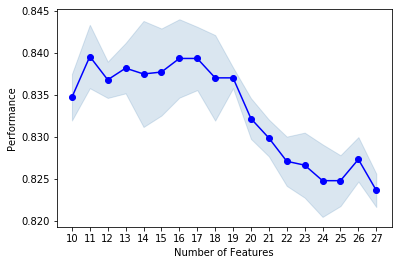

In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
forest =RandomForestClassifier(bootstrap = False,verbose=0,random_state=42,n_estimators=100)
cv = StratifiedKFold(random_state=42,n_splits=5,shuffle=True) 
seqbacksel_rf = SFS(forest, k_features = (10, 27), forward = False, floating = False, scoring = 'accuracy', cv = cv, n_jobs = -1)
seqbacksel_rf = seqbacksel_rf.fit(train_new_small[learn_cols],train_new_small[target_col])
print('best combination (ACC: %.3f): %s\n' % (seqbacksel_rf.k_score_, seqbacksel_rf.k_feature_idx_))
print('all subsets:\n', seqbacksel_rf.subsets_)
plot_sfs(seqbacksel_rf.get_metric_dict(), kind='std_err');

(ACC: 0.840): (0, 2, 3, 6, 7, 8, 9, 12, 13, 19, 20)
{'feature_idx': (0, 2, 3, 6, 7, 8, 9, 12, 13, 19, 20), 'cv_scores': array([0.84027778, 0.85300926, 0.83796296, 0.83680556, 0.82986111]), 'avg_score': 0.8395833333333332, 'feature_names': ('Elevation', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'soil_cat', 'wild_cat', 'Hyd_2_Fire', 'Fire_2_Road', 'wild_stone', 'soil_wild_cat')},

In [17]:
learn_cols_tuned=['Elevation', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'soil_cat', 'wild_cat', 'Hyd_2_Fire', 'Fire_2_Road', 'wild_stone', 'soil_wild_cat']

In [18]:
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [20]:
#first I split the data
X_train, X_val, Y_train, Y_val = train_test_split(train_new_small[learn_cols], train_new_small[target_col], stratify=train_new_small[target_col],  test_size=0.2,random_state=42)

In [21]:
forest_model=RandomForestClassifier(bootstrap = False,verbose=0,random_state=42,n_estimators=100)
forest_model.fit(X_train,Y_train)
perm = PermutationImportance(forest_model, random_state=1).fit(X_val, Y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.1977 ± 0.0311,Elevation
0.0222 ± 0.0101,Horizontal_Distance_To_Roadways
0.0144 ± 0.0131,soil_wild_cat
0.0120 ± 0.0043,if_Leighcan
0.0116 ± 0.0096,Horizontal_Distance_To_Fire_Points
0.0076 ± 0.0060,dif_shade
0.0072 ± 0.0063,Fire_2_Road
0.0069 ± 0.0083,Horizontal_Distance_To_Hydrology
0.0062 ± 0.0068,Hyd_2_Road
0.0058 ± 0.0044,Hyd_2_Fire


In [22]:
print("special acc is: ",accuracy_score(Y_val,forest_model.predict(X_val.values)))

special acc is:  0.8194444444444444


In [67]:
#first I split the data
X_train, X_val, Y_train, Y_val = train_test_split(train_new_small[learn_cols_tuned], train_new_small[target_col], stratify=train_new_small[target_col],  test_size=0.2,random_state=42)

In [24]:
forest_model=RandomForestClassifier(bootstrap = False,verbose=0,random_state=42,n_estimators=100)
forest_model.fit(X_train,Y_train)
perm = PermutationImportance(forest_model, random_state=1).fit(X_val, Y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.2269 ± 0.0143,Elevation
0.0530 ± 0.0143,Horizontal_Distance_To_Roadways
0.0319 ± 0.0166,Horizontal_Distance_To_Fire_Points
0.0257 ± 0.0226,soil_wild_cat
0.0250 ± 0.0107,Vertical_Distance_To_Hydrology
0.0225 ± 0.0078,Fire_2_Road
0.0178 ± 0.0150,Hyd_2_Fire
0.0155 ± 0.0048,Hillshade_3pm
0.0141 ± 0.0093,wild_stone
0.0058 ± 0.0137,soil_cat


In [25]:
print("special acc is: ",accuracy_score(Y_val,forest_model.predict(X_val.values)))

special acc is:  0.8298611111111112


In [26]:
confusion_matrix(Y_val.values,forest_model.predict(X_val.values))

array([[361,  71],
       [ 76, 356]], dtype=int64)

#### Encoding

In [87]:
#first I split the data
X_train, X_val, Y_train, Y_val = train_test_split(train_new_small[learn_cols_tuned], train_new_small[target_col], stratify=train_new_small[target_col],  test_size=0.2,random_state=42)

In [88]:
X_train_2,X_val_2=full_enc_6(pd.concat([X_train,Y_train],axis=1),['soil_cat'],target_col,100,3,[2],df_test=X_val)

In [89]:
X_train_2=X_train_2.drop(columns=target_col)

In [90]:
forest_model=RandomForestClassifier(bootstrap = False,verbose=0,random_state=42,n_estimators=100)
forest_model.fit(X_train_2,Y_train)
perm = PermutationImportance(forest_model, random_state=1).fit(X_val_2, Y_val)
eli5.show_weights(perm, feature_names = X_val_2.columns.tolist())

Weight,Feature
0.2093 ± 0.0317,Elevation
0.0491 ± 0.0112,Horizontal_Distance_To_Roadways
0.0347 ± 0.0133,Horizontal_Distance_To_Fire_Points
0.0271 ± 0.0043,Vertical_Distance_To_Hydrology
0.0231 ± 0.0151,Fire_2_Road
0.0218 ± 0.0115,soil_cat_enc_2
0.0211 ± 0.0142,Hyd_2_Fire
0.0164 ± 0.0064,soil_wild_cat
0.0162 ± 0.0055,Hillshade_3pm
0.0137 ± 0.0112,soil_cat


In [91]:
print("special acc is: ",accuracy_score(Y_val,forest_model.predict(X_val_2.values)))

special acc is:  0.8321759259259259


Result, encoding seems to work a little

optimization

In [31]:
def Bayes_RandomTrees(n_estimators, max_depth,max_features):
    
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    
    assert type(n_estimators) == int
    assert type(max_depth) == int
    
    etc =RandomForestClassifier(n_estimators = n_estimators,max_features = max_features,bootstrap = False,max_depth=max_depth,verbose=0,random_state=42)
    cv = StratifiedKFold(random_state=42,n_splits=5,shuffle=True) 
    CrossValidationscores = cross_val_score(etc, train_new_small[learn_cols_tuned], train_new_small[target_col], cv=cv, scoring = 'accuracy',n_jobs=-1)
    
    score = np.mean(CrossValidationscores)
    
    return score

In [32]:
params = {'n_estimators' : (50, 500),
          'max_depth' : (30, 150),
        'max_features' : (.2,0.7)} 

RandomTreeBO = BayesianOptimization(Bayes_RandomTrees, params, random_state = 42)

print(RandomTreeBO.space.keys)

init_points = 50
n_iter = 50

['max_depth', 'max_features', 'n_estimators']


In [33]:
RandomTreeBO.maximize(init_points = init_points,  n_iter = n_iter,   acq = 'ucb',    xi = 0.0,        alpha = 1e-6)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8197   |  74.94    |  0.6754   |  379.4    |
|  2        |  0.8394   |  101.8    |  0.278    |  120.2    |
|  3        |  0.8273   |  36.97    |  0.6331   |  320.5    |
|  4        |  0.837    |  115.0    |  0.2103   |  486.5    |
|  5        |  0.8391   |  129.9    |  0.3062   |  131.8    |
|  6        |  0.8368   |  52.01    |  0.3521   |  286.1    |
|  7        |  0.8368   |  81.83    |  0.3456   |  325.3    |
|  8        |  0.837    |  46.74    |  0.3461   |  214.9    |
|  9        |  0.8299   |  84.73    |  0.5926   |  139.9    |
|  10       |  0.8296   |  91.71    |  0.4962   |  70.9     |
|  11       |  0.8405   |  102.9    |  0.2853   |  79.27    |
|  12       |  0.8192   |  143.9    |  0.6828   |  413.8    |
|  13       |  0.8391   |  66.55    |  0.2488   |  357.9    |
|  14       |  0.837    |  82.82    |  0.261    |  272.8    |
|  15   

|  81       |  0.838    |  30.43    |  0.2025   |  333.1    |
|  82       |  0.8373   |  121.7    |  0.2048   |  148.4    |
|  83       |  0.8398   |  124.7    |  0.2006   |  69.29    |
|  84       |  0.8384   |  74.85    |  0.2069   |  196.8    |
|  85       |  0.8396   |  98.23    |  0.2013   |  344.2    |
|  86       |  0.8391   |  129.0    |  0.2045   |  384.1    |
|  87       |  0.838    |  90.08    |  0.2021   |  290.7    |
|  88       |  0.8359   |  109.5    |  0.2011   |  131.0    |
|  89       |  0.8366   |  78.11    |  0.2021   |  117.8    |
|  90       |  0.838    |  53.83    |  0.2035   |  55.78    |
|  91       |  0.8366   |  65.1     |  0.2004   |  149.1    |
|  92       |  0.8373   |  148.6    |  0.2088   |  230.9    |
|  93       |  0.8368   |  52.69    |  0.2047   |  455.5    |
|  94       |  0.8377   |  56.31    |  0.2038   |  222.6    |
|  95       |  0.8396   |  64.32    |  0.2083   |  342.0    |
|  96       |  0.8387   |  149.4    |  0.2087   |  386.1    |
|  97   

In [34]:
print(RandomTreeBO.max)

{'target': 0.8405092592592591, 'params': {'max_depth': 102.9053822281726, 'max_features': 0.2852620618436458, 'n_estimators': 79.27321684337578}}


{'target': 0.8405092592592591, 'params': {'max_depth': 102.9053822281726, 'max_features': 0.2852620618436458, 'n_estimators': 79.27321684337578}}


Now final fitting; The boost from encoding is so small that I will skip it

In [35]:
def train_forest(data_train,data_val,learn_cols,target_col):
    #imput is data in pandas DataFrame with learn columns and target columns
    #first train the full model
    forest_model=RandomForestClassifier(n_estimators = 80,max_features = 'auto',bootstrap = False,max_depth=100,verbose=0)
    forest_model.fit(data_train[learn_cols].values, data_train[target_col].values)
    forest_model_prob=forest_model.predict_proba(data_val[learn_cols].values)
    return forest_model_prob

In [39]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
result=pd.DataFrame(np.zeros([train_new.shape[0],2]))

In [40]:
i=0
for train_index, test_index in skf.split(train_new[learn_cols_tuned],train_new[target_col]):
    data_train=train_new.iloc[train_index,:].copy()
    data_train_small=data_train[data_train[target_col]<3].copy()
    data_val=train_new.iloc[test_index,:].copy()
    result.iloc[test_index,:]=train_forest(data_train_small,data_val,learn_cols_tuned,target_col)
    print('stage done ',i)
    i+=1

stage done  0
stage done  1
stage done  2
stage done  3
stage done  4


In [41]:
predic=np.argmax(result.values,1)+1

In [46]:
#the accuracy of validation
print("acc is: ",accuracy_score(train_new[target_col].values,predic))
confusion_matrix(train_new[target_col].values,predic)

acc is:  0.23743386243386244


array([[1794,  366,    0,    0,    0,    0,    0],
       [ 364, 1796,    0,    0,    0,    0,    0],
       [   7, 2153,    0,    0,    0,    0,    0],
       [  92, 2068,    0,    0,    0,    0,    0],
       [ 167, 1993,    0,    0,    0,    0,    0],
       [  49, 2111,    0,    0,    0,    0,    0],
       [2036,  124,    0,    0,    0,    0,    0]], dtype=int64)

In [47]:
#saving
result.to_csv('forest_smal_train_prob.csv')

### Final Predicting

In [49]:
forest_full=RandomForestClassifier(n_estimators = 80,max_features = 'auto',bootstrap = False,max_depth=100,verbose=0)
forest_full.fit(train_new_small[learn_cols_tuned].values, train_new_small[target_col].values)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
test=pd.read_csv(os.path.join(os.getcwd(),'test.csv.zip'))
test_new=add_cat(test,soil_type,wild_type,soil_names,hill_feat)

In [51]:
forest_pred_test=pd.DataFrame(forest_full.predict_proba(test_new[learn_cols_tuned]),index=test.Id.values)

In [52]:
forest_pred_test.to_csv('forest_smal_test_prob.csv')